In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Load dataset
df = pd.read_csv("Real-Time_Traffic_Incident_Reports_20250818.csv")



In [2]:
df = df[(df['Latitude'] != 0)]
df = df[(df['Longitude'] != 0)]
df = df[(df['Latitude'] <= 35)]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433052 entries, 0 to 434150
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Traffic Report ID  433052 non-null  object 
 1   Published Date     433052 non-null  object 
 2   Issue Reported     433052 non-null  object 
 3   Location           433052 non-null  object 
 4   Latitude           433052 non-null  float64
 5   Longitude          433052 non-null  float64
 6   Address            433052 non-null  object 
 7   Status             431365 non-null  object 
 8   Status Date        433052 non-null  object 
 9   Agency             77356 non-null   object 
dtypes: float64(2), object(8)
memory usage: 36.3+ MB


In [4]:
df['Published Date'] = pd.to_datetime(df['Published Date'])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433052 entries, 0 to 434150
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Traffic Report ID  433052 non-null  object             
 1   Published Date     433052 non-null  datetime64[ns, UTC]
 2   Issue Reported     433052 non-null  object             
 3   Location           433052 non-null  object             
 4   Latitude           433052 non-null  float64            
 5   Longitude          433052 non-null  float64            
 6   Address            433052 non-null  object             
 7   Status             431365 non-null  object             
 8   Status Date        433052 non-null  object             
 9   Agency             77356 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 36.3+ MB


In [6]:
# Feature engineering: extract time features
df['hour'] = df['Published Date'].dt.time


In [7]:
df['hour'] = df['Published Date'].dt.hour
df['dayofweek'] = df['Published Date'].dt.dayofweek


In [8]:
# Group by hour and day of week (to get incident counts)
hourly_counts = df.groupby(['dayofweek', 'hour']).size().reset_index(name='count')
# Features (X) and target (y)
X = hourly_counts[['dayofweek', 'hour']]
y = hourly_counts['count']
# Train Linear Regression
model = LinearRegression()
model.fit(X, y)
# Predictions
y_pred = model.predict(X)


In [9]:
# Evaluate
print("R² score:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))




R² score: 0.4117214902516936
MSE: 906433.6531742489


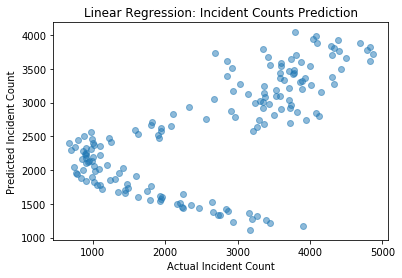

In [10]:
# Plot actual vs predicted
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Actual Incident Count")
plt.ylabel("Predicted Incident Count")
plt.title("Linear Regression: Incident Counts Prediction")
plt.show()

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [12]:
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)


In [14]:
# Aggregate: incidents per hour per day
hourly_counts = df.groupby(['dayofweek','hour', 'is_weekend']).size().reset_index(name='count')

# Features and target
X = hourly_counts[['dayofweek','hour','is_weekend']]
y = hourly_counts['count']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
hourly_counts

,dayofweek,hour,is_weekend,count
0,0,0,0,2843
1,0,1,0,2640
2,0,2,0,2241
3,0,3,0,1796
4,0,4,0,1310
...,...,...,...,...
163,6,19,1,3026
164,6,20,1,2855
165,6,21,1,2920
166,6,22,1,2855


In [17]:
# Initialize Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R² Score: 0.9799815985813956
RMSE: 171.67292983529845


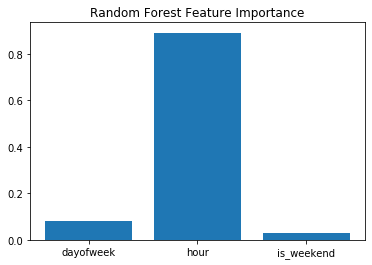

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importance = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(6,4))
plt.bar(features, importance)
plt.title("Random Forest Feature Importance")
plt.show()


In [22]:
# Put results into a DataFrame for easier comparison
results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = y_pred

# Sort by time-ish order (dayofweek + hour) to make plots readable
results = results.sort_values(['dayofweek','hour'])

In [23]:
results

,dayofweek,hour,is_weekend,actual,predicted
9,0,9,0,792,823.13
12,0,12,0,2961,3156.50
15,0,15,0,3141,3393.62
16,0,16,0,3358,3463.73
18,0,18,0,3715,3686.38
19,0,19,0,3602,3667.67
24,1,0,0,3162,2938.77
29,1,5,0,778,917.03
30,1,6,0,732,865.72
31,1,7,0,856,955.73


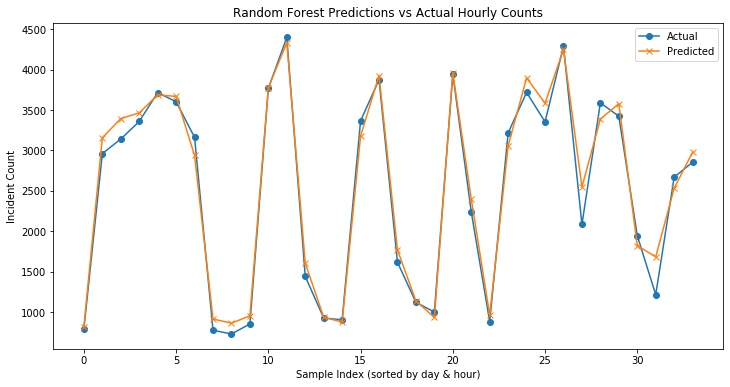

In [24]:
# Sort by time-ish order (dayofweek + hour) to make plots readable
results = results.sort_values(['dayofweek','hour'])

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(results['actual'].values, label="Actual", marker='o')
plt.plot(results['predicted'].values, label="Predicted", marker='x')
plt.title("Random Forest Predictions vs Actual Hourly Counts")
plt.xlabel("Sample Index (sorted by day & hour)")
plt.ylabel("Incident Count")
plt.legend()
plt.show()

In [25]:
# Example: add lagged feature
hourly_counts['prev_hour_count'] = hourly_counts['count'].shift(1).fillna(0)

X = hourly_counts[['dayofweek','hour','is_weekend','prev_hour_count']]
y = hourly_counts['count']

# Split, train, predict as before
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R² Score: 0.9601077565914393
RMSE: 242.3434869026144


In [26]:
#Put results into a DataFrame for easier comparison
results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = y_pred

# Sort by time-ish order (dayofweek + hour) to make plots readable
results = results.sort_values(['dayofweek','hour'])

In [27]:
results

,dayofweek,hour,is_weekend,prev_hour_count,actual,predicted
9,0,9,0,898.0,792,825.60
12,0,12,0,1799.0,2961,2162.59
15,0,15,0,3355.0,3141,3513.48
16,0,16,0,3141.0,3358,3333.17
18,0,18,0,3579.0,3715,3756.29
19,0,19,0,3715.0,3602,3694.44
24,1,0,0,3797.0,3162,3257.37
29,1,5,0,1015.0,778,888.80
30,1,6,0,778.0,732,919.25
31,1,7,0,732.0,856,937.04


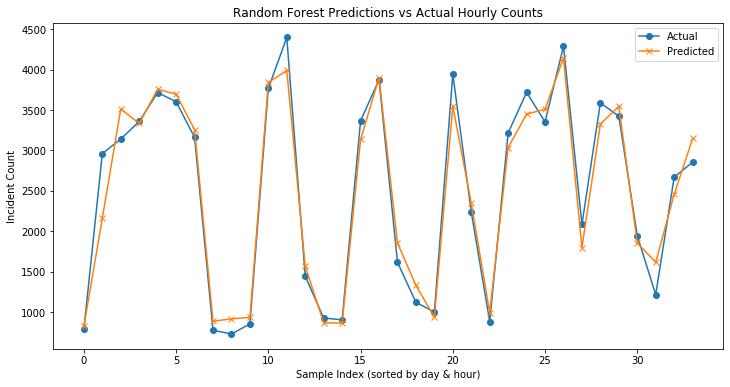

In [28]:
# Sort by time-ish order (dayofweek + hour) to make plots readable
results = results.sort_values(['dayofweek','hour'])

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(results['actual'].values, label="Actual", marker='o')
plt.plot(results['predicted'].values, label="Predicted", marker='x')
plt.title("Random Forest Predictions vs Actual Hourly Counts")
plt.xlabel("Sample Index (sorted by day & hour)")
plt.ylabel("Incident Count")
plt.legend()
plt.show()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433052 entries, 0 to 434150
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Traffic Report ID  433052 non-null  object             
 1   Published Date     433052 non-null  datetime64[ns, UTC]
 2   Issue Reported     433052 non-null  object             
 3   Location           433052 non-null  object             
 4   Latitude           433052 non-null  float64            
 5   Longitude          433052 non-null  float64            
 6   Address            433052 non-null  object             
 7   Status             431365 non-null  object             
 8   Status Date        433052 non-null  object             
 9   Agency             77356 non-null   object             
 10  hour               433052 non-null  int64              
 11  dayofweek          433052 non-null  int64              
 12  is_weekend         433052 non-

In [30]:
df

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date,Agency,hour,dayofweek,is_weekend
0,F350D780EA8AAA48030B4DB64F790C14DBCD757F_17096...,2024-03-06 01:29:39+00:00,Stalled Vehicle,POINT (-97.705874 30.32358),30.323580,-97.705874,E 290 Svrd Wb To Ih 35 Nb Ramp / N Ih 35 Svrd ...,ARCHIVED,03/06/2024 02:10:12 AM +0000,AUSTIN PD,1,2,0
1,042338D46C2028808F298DEC735DC7ADF0C162F6_17096...,2024-03-06 01:26:42+00:00,Crash Urgent,POINT (-97.698567 30.342505),30.342505,-97.698567,8024 N Ih 35 Svrd Sb,ARCHIVED,03/06/2024 02:45:13 AM +0000,AUSTIN PD,1,2,0
2,BE73E73B642ECB6C6EDB4A52875A8017F69DFE5E_17080...,2024-02-15 22:17:48+00:00,LOOSE LIVESTOCK,POINT (-97.717911 30.0578),30.057800,-97.717911,12400 Glass Rd,ARCHIVED,02/15/2024 11:33:08 PM +0000,TRAVIS COUNTY SHERIF,22,3,0
3,A5909010064EF753C5F090A07CFCDDFBF25E38F3_15865...,2020-04-10 21:31:11+00:00,TRFC HAZD/ DEBRIS,POINT (-97.866676 30.140878),30.140878,-97.866676,S Sh 45 W Eb & S Sh 45 W Eb To Bliss Spillar Ramp,ARCHIVED,04/10/2020 09:55:03 PM +0000,NaN,21,4,0
4,4A6C39763AD109EB75CE31C1EBFD53A0E883EE68_16543...,2022-06-04 17:51:05+00:00,Traffic Hazard,POINT (-97.825791 30.455444),30.455444,-97.825791,Anderson Mill Rd & N Fm 620 Rd,ARCHIVED,06/04/2022 06:20:03 PM +0000,NaN,17,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434146,D2B77EBA190F0947FEC6F4EA390E31488AE19D61_17555...,2025-08-18 18:41:09+00:00,TRFC HAZD/ DEBRIS,POINT (-97.925448 30.52142),30.521420,-97.925448,23506-23642 Nameless Rd,ARCHIVED,08/18/2025 07:10:18 PM +0000,TRAVIS COUNTY SHERIF,18,0,0
434147,F220B708923B41B9B9EE5F9CDBB561FBE9C1A20B_17555...,2025-08-18 19:14:11+00:00,Traffic Hazard,POINT (-97.728476 30.264813),30.264813,-97.728476,1300-1319 E 7th St,ACTIVE,08/18/2025 07:15:16 PM +0000,AUSTIN PD,19,0,0
434148,FB56923215472C0C9CBE213D3B9E1F425C8C40A0_17555...,2025-08-18 18:30:58+00:00,Crash Urgent,POINT (-97.758179 30.219716),30.219716,-97.758179,0 E Ben White To Ih 35 Nb Ramp,ARCHIVED,08/18/2025 07:15:17 PM +0000,AUSTIN PD,18,0,0
434149,A6FB51F36210FA55A23ACA9E4C8C3F346506A42A_17555...,2025-08-18 18:41:49+00:00,COLLISN/ LVNG SCN,POINT (-97.603512 30.253391),30.253391,-97.603512,12400-13117 Fm 969 Rd,ARCHIVED,08/18/2025 07:25:13 PM +0000,TRAVIS COUNTY SHERIF,18,0,0


In [31]:
df['Date'] = pd.to_datetime(df['Published Date']).dt.floor('D')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433052 entries, 0 to 434150
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Traffic Report ID  433052 non-null  object             
 1   Published Date     433052 non-null  datetime64[ns, UTC]
 2   Issue Reported     433052 non-null  object             
 3   Location           433052 non-null  object             
 4   Latitude           433052 non-null  float64            
 5   Longitude          433052 non-null  float64            
 6   Address            433052 non-null  object             
 7   Status             431365 non-null  object             
 8   Status Date        433052 non-null  object             
 9   Agency             77356 non-null   object             
 10  hour               433052 non-null  int64              
 11  dayofweek          433052 non-null  int64              
 12  is_weekend         433052 non-

In [33]:
df

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date,Agency,hour,dayofweek,is_weekend,Date
0,F350D780EA8AAA48030B4DB64F790C14DBCD757F_17096...,2024-03-06 01:29:39+00:00,Stalled Vehicle,POINT (-97.705874 30.32358),30.323580,-97.705874,E 290 Svrd Wb To Ih 35 Nb Ramp / N Ih 35 Svrd ...,ARCHIVED,03/06/2024 02:10:12 AM +0000,AUSTIN PD,1,2,0,2024-03-06 00:00:00+00:00
1,042338D46C2028808F298DEC735DC7ADF0C162F6_17096...,2024-03-06 01:26:42+00:00,Crash Urgent,POINT (-97.698567 30.342505),30.342505,-97.698567,8024 N Ih 35 Svrd Sb,ARCHIVED,03/06/2024 02:45:13 AM +0000,AUSTIN PD,1,2,0,2024-03-06 00:00:00+00:00
2,BE73E73B642ECB6C6EDB4A52875A8017F69DFE5E_17080...,2024-02-15 22:17:48+00:00,LOOSE LIVESTOCK,POINT (-97.717911 30.0578),30.057800,-97.717911,12400 Glass Rd,ARCHIVED,02/15/2024 11:33:08 PM +0000,TRAVIS COUNTY SHERIF,22,3,0,2024-02-15 00:00:00+00:00
3,A5909010064EF753C5F090A07CFCDDFBF25E38F3_15865...,2020-04-10 21:31:11+00:00,TRFC HAZD/ DEBRIS,POINT (-97.866676 30.140878),30.140878,-97.866676,S Sh 45 W Eb & S Sh 45 W Eb To Bliss Spillar Ramp,ARCHIVED,04/10/2020 09:55:03 PM +0000,NaN,21,4,0,2020-04-10 00:00:00+00:00
4,4A6C39763AD109EB75CE31C1EBFD53A0E883EE68_16543...,2022-06-04 17:51:05+00:00,Traffic Hazard,POINT (-97.825791 30.455444),30.455444,-97.825791,Anderson Mill Rd & N Fm 620 Rd,ARCHIVED,06/04/2022 06:20:03 PM +0000,NaN,17,5,1,2022-06-04 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434146,D2B77EBA190F0947FEC6F4EA390E31488AE19D61_17555...,2025-08-18 18:41:09+00:00,TRFC HAZD/ DEBRIS,POINT (-97.925448 30.52142),30.521420,-97.925448,23506-23642 Nameless Rd,ARCHIVED,08/18/2025 07:10:18 PM +0000,TRAVIS COUNTY SHERIF,18,0,0,2025-08-18 00:00:00+00:00
434147,F220B708923B41B9B9EE5F9CDBB561FBE9C1A20B_17555...,2025-08-18 19:14:11+00:00,Traffic Hazard,POINT (-97.728476 30.264813),30.264813,-97.728476,1300-1319 E 7th St,ACTIVE,08/18/2025 07:15:16 PM +0000,AUSTIN PD,19,0,0,2025-08-18 00:00:00+00:00
434148,FB56923215472C0C9CBE213D3B9E1F425C8C40A0_17555...,2025-08-18 18:30:58+00:00,Crash Urgent,POINT (-97.758179 30.219716),30.219716,-97.758179,0 E Ben White To Ih 35 Nb Ramp,ARCHIVED,08/18/2025 07:15:17 PM +0000,AUSTIN PD,18,0,0,2025-08-18 00:00:00+00:00
434149,A6FB51F36210FA55A23ACA9E4C8C3F346506A42A_17555...,2025-08-18 18:41:49+00:00,COLLISN/ LVNG SCN,POINT (-97.603512 30.253391),30.253391,-97.603512,12400-13117 Fm 969 Rd,ARCHIVED,08/18/2025 07:25:13 PM +0000,TRAVIS COUNTY SHERIF,18,0,0,2025-08-18 00:00:00+00:00


In [34]:
# Floor to day
daily_counts = df.groupby(df['Date'].dt.floor("D")).size()

# Assign daily frequency (prevents ARIMA warnings)
daily_counts = daily_counts.asfreq("D")


In [35]:
daily_counts

Date
2017-09-26 00:00:00+00:00     23.0
2017-09-27 00:00:00+00:00    114.0
2017-09-28 00:00:00+00:00    226.0
2017-09-29 00:00:00+00:00    197.0
2017-09-30 00:00:00+00:00    125.0
                             ...  
2025-08-14 00:00:00+00:00    130.0
2025-08-15 00:00:00+00:00    141.0
2025-08-16 00:00:00+00:00    109.0
2025-08-17 00:00:00+00:00    111.0
2025-08-18 00:00:00+00:00    101.0
Freq: D, Length: 2884, dtype: float64

In [36]:
from statsmodels.tsa.arima.model import ARIMA


In [37]:
model = ARIMA(daily_counts, order=(1,1,1))
fit = model.fit()
forecast = fit.get_forecast(steps=7)
# Build forecast series with proper dates
forecast_index = pd.date_range(start=daily_counts.index[-1] + pd.Timedelta(days=1),
                               periods=7, freq="D")
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
print("Forecast:")
print(forecast_series)


Forecast:
2025-08-19 00:00:00+00:00    115.439994
2025-08-20 00:00:00+00:00    119.776894
2025-08-21 00:00:00+00:00    121.079436
2025-08-22 00:00:00+00:00    121.470641
2025-08-23 00:00:00+00:00    121.588135
2025-08-24 00:00:00+00:00    121.623423
2025-08-25 00:00:00+00:00    121.634021
Freq: D, dtype: float64
